## ClimSim paper presentation

__Note on the code :__  As explained in the video, ClimSim dataset comes with a set of utils and data processing tools (code in `lib/ClimSim/` folder). However it's a quite complex pipeline which wasn't able to my computer and that was difficult to debug.

Thus, rather than adapting the previous code I rewrote basic functions that allows plotting, data batching etc. All this methods were developed in adjacent notebooks ( `.old/data_shrader.ipynb, .old/deep_learning.ipynb...`) which are available if needed.

All the code in `/lib/custom` and in this notebook is the code I rewrote.

### Importation

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os

import torch 
from torch.utils.data import Dataset, Subset
import re

from lib import data

from lib.mapper import ClimSimMapper
from lib.physics import get_isa_conditions
from lib.evaluation import MetricsEvaluator

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Subset

from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

import xarray as xr
import os
import torch
from functools import reduce 

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

torch.device("cpu")

LOW_RES_SAMPLE_PATH = "public_data/ClimSim_low-res"
LOW_RES_GRID_PATH = "public_data/ClimSim_low-res/ClimSim_low-res_grid-info.nc"
GRID_PATH = LOW_RES_GRID_PATH

HIGH_RES_SAMPLE_PATH = "data/ClimSim_high-res/train/0002-01"
HIGH_RES_GRID_PATH = "data/ClimSim_high-res/ClimSim_high-res_grid-info.nc"

ZARR_PATH = "public_data/ClimSim_low-res_validation.zarr"
NORM_PATH = "lib/ClimSim/preprocessing/normalizations/"

CNN_PATH = "ClimSim/baseline_models/CNN/model/"
MLP_PATH = "lib/ClimSim/baseline_models/MLP/model/backup_phase-7_retrained_models_step2_lot-147_trial_0027.best.h5"



### High-Res samples vizualisation

The deep learning part of the notebook will essentially focus on *low-res* version of CLimSim for storage and computing reasons. However it's still very interesting to see what's the *high-res* version include, especilaly look at the map density of information.

<span style="color:red">Do not run the plotting code, because the samples are not on the git (too heavy)</span>

In [14]:
SVALBARD_COORDS = (78.2232, 15.6469, "Svalbard")  # (lat, lon)
PARIS_COORDS = (48.8566, 2.3522, "Paris")      # (lat, lon)
TOKYO_COORDS = (35.6762, 139.6503, "Tokyo")   # (lat, lon)

In [35]:
grid_info = xr.open_dataset(HIGH_RES_GRID_PATH)
samples_list = os.listdir(HIGH_RES_SAMPLE_PATH)

sample_ds = xr.open_dataset(os.path.join(HIGH_RES_SAMPLE_PATH, samples_list[0]))
grid_ds = xr.open_dataset(HIGH_RES_GRID_PATH)

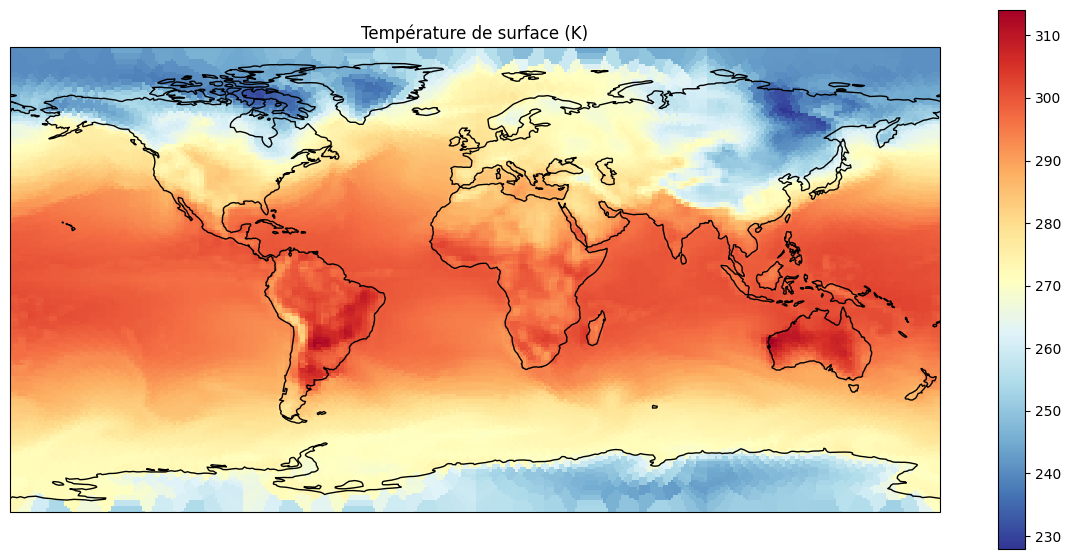

In [16]:
mapper = ClimSimMapper(grid_info)
sample_to_plot = sample_ds['state_t'].isel(lev=-1).values
mapper.plot_smooth_map(sample_to_plot, title="Température de surface (K)")

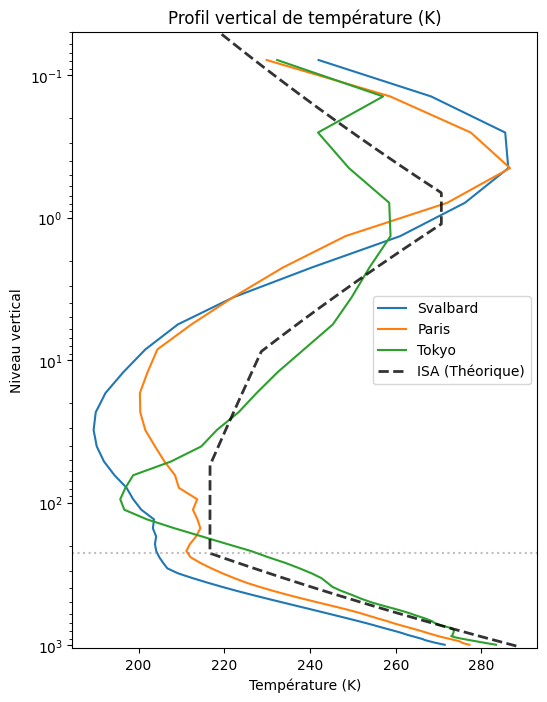

In [17]:
FEATURE = 'state_t'  # Température

list_of_POIs = [SVALBARD_COORDS, PARIS_COORDS, TOKYO_COORDS]
fts = []
for pt in list_of_POIs:
    index = mapper.return_closer_gridpoint_index(pt[0], pt[1])
    fts.append(sample_ds[FEATURE].isel(ncol=index).values)

altitude_levels = grid_ds['lev'].values



h_range = np.linspace(0, 80000, num=1000) # Altitudes de 0 à 80 km
T_isa, P_isa_pa, _ = get_isa_conditions(h_range)
P_isa_hpa = P_isa_pa / 100.0  # Conversion en hPa pour matcher tes 'lev'

plt.figure(figsize=(6, 8))
for plot_idx, ft in enumerate(fts):
    plt.plot(ft, altitude_levels, label=list_of_POIs[plot_idx][2])
plt.plot(T_isa, P_isa_hpa, label="ISA (Théorique)", linestyle='--', color='k', linewidth=2, alpha=0.8)

plt.yscale('log')          # Échelle logarithmique pour la pression
plt.gca().invert_yaxis()   # Inverser pour avoir 1000 hPa en bas
plt.ylim(1050, 0.05)       # On règle les limites (du sol au sommet)

# Ajout de lignes de repère pour les couches
plt.axhline(226, color='gray', linestyle=':', alpha=0.5) # Limite approx Tropopause (~200hPa)

plt.title("Profil vertical de température (K)")
plt.xlabel("Température (K)")
plt.ylabel("Niveau vertical")
plt.yscale('log')
plt.legend()

## Data Downloading and Chunking
### Intro

As mentionned the dataset is quite huge. Indeed the high-res version is __*70 TB*__ while the low-res is __*700 Gb*__. Each sample of the dataset correspond to an Earth image at a given timestamp, and there's 9 years of data available.

In order to work with this dataset I wanted to try to train one of the models presented in the performance benchmark. I chose to implement the simplest (MLP) but you'll soon understand that the challenge doesn't necessarily comes from the model architechture complexity.

I wanted to work with **2 years** of data to avoid having a biased model. However this represents millions of samples and reading was too slow on my computer, which motivated the conversion in `.zarr` format. For readability, all this code is in `data_download_convert.ipynb`.

## Data Extraction and Processing classes


The core of the pipeline rely on the implementation of this data class. It's way much simpler than the original (you can check `lib/ClimSim/climsim_utils/data_utils`)

However you will find out that I have a Pytorch and a Keras version. This is because I started training the MLP with pytorch before realising that the baseline models were trained using keras

In [36]:
class ClimSimBase:
    def __init__(self, zarr_path, grid_path, norm_path, features, num_latlon = 384, normalize=True):
        self.ds = xr.open_zarr(zarr_path, chunks=None)
        self.features = features
        self.features_list = self.__get_features__()
        self.normalize_flag = normalize
        self.normalize = normalize  
        self.num_latlon = num_latlon
        self.grid = xr.open_dataset(grid_path, engine="netcdf4")
        
        self.grid['area_wgt'] = self.grid['area']/self.grid['area'].mean(dim = 'ncol')
        self.area_wgt = self.grid['area_wgt'].values

        self.input_vars = [v for v in self.features_list if 'in' in v]
        self.output_vars = [v for v in self.features_list if 'out' in v]

        self.grav    = 9.80616    # acceleration of gravity ~ m/s^2
        self.cp      = 1.00464e3  # specific heat of dry air   ~ J/kg/K
        self.lv      = 2.501e6    # latent heat of evaporation ~ J/kg
        self.lf      = 3.337e5    # latent heat of fusion      ~ J/kg
        self.lsub    = self.lv + self.lf    # latent heat of sublimation ~ J/kg
        self.rho_air = 101325/(6.02214e26*1.38065e-23/28.966)/273.15 # density of dry air at STP  ~ kg/m^3
        self.rho_h20 = 1.e3       # density of fresh water     ~ kg/m^ 3

        self.target_energy_conv = {'ptend_t':self.cp,
                            'ptend_q0001':self.lv,
                            'ptend_q0002':self.lv,
                            'ptend_q0003':self.lv,
                            'ptend_qn':self.lv,
                            'ptend_wind': None,
                            'cam_out_NETSW':1.,
                            'cam_out_FLWDS':1.,
                            'cam_out_PRECSC':self.lv*self.rho_h20,
                            'cam_out_PRECC':self.lv*self.rho_h20,
                            'cam_out_SOLS':1.,
                            'cam_out_SOLL':1.,
                            'cam_out_SOLSD':1.,
                            'cam_out_SOLLD':1.
                            }
        
        
        self.dp = None 
        self.pressure_grid = None

        self.input_mean = xr.open_dataset(os.path.join(norm_path, "inputs/input_mean.nc"), engine="h5netcdf")
        self.input_std = xr.open_dataset(os.path.join(norm_path, "inputs/input_std.nc"), engine="h5netcdf")
        self.input_max = xr.open_dataset(os.path.join(norm_path, "inputs/input_max.nc"), engine="h5netcdf")
        self.input_min = xr.open_dataset(os.path.join(norm_path, "inputs/input_min.nc"), engine="h5netcdf")
        self.output_scale = xr.open_dataset(os.path.join(norm_path, "outputs/output_scale.nc"), engine="h5netcdf")

    def __get_features__(self):
        feat = np.concatenate([self.features["features"]["multilevel"], self.features["features"]["surface"]])
        target = np.concatenate([self.features["target"]["tendancies"], self.features["target"]["surface"]])
        return np.concatenate([feat, target])

    def _prepare_data(self, idx):
        x = self.process_list(self.input_vars, idx, is_input=True)
        y = self.process_list(self.output_vars, idx, is_input=False)
        return x, y

    def process_list(self, vars_list, idx, is_input=True):
        out_list = []
        n_geo = self.num_latlon # 384

        for var in vars_list:
            if "ptend" in var:
                # Cette fonction doit renvoyer du (Time, 384, 60)
                data = self._calculate_tendency_on_fly(var, idx)
                if data.ndim == 2: # Si (384, 60)
                    data = data[np.newaxis, :, :]
            
            else:
                da = self.ds[var].isel(sample=idx)
                
                # Redressement par nom de dimension Xarray
                if 'lev' in da.dims:
                    if "sample" in da.dims:
                        data = da.transpose('sample', 'ncol', 'lev').values
                    else:
                        data = da.transpose('ncol', 'lev').values[np.newaxis, :, :]
                else:
                    if "sample" in da.dims:
                        # Surface : (Time, 384)
                        data = da.values[:, :, np.newaxis]  # Ajouter une dimension lev=1
                    else:
                        # Surface : (Time, 384) -> (Time, 384, 1)
                        data = da.values[np.newaxis, :, np.newaxis]
            
            # 2. Normalisation (Maintenant data est garanti (N, 384, L))
            data = self._normalize_var(data, var, is_input=is_input)
            out_list.append(data.astype(np.float32))

        # 3. Concaténation et aplatissement
        combined = np.concatenate(out_list, axis=-1)
        return combined.reshape(-1, combined.shape[-1])

    def __len__(self):
        return self.ds.dims['sample']

    def _calculate_tendency_on_fly(self, var, idx):
        dt = 1200
        mapping = {
            'out_ptend_t': ('out_state_t', 'in_state_t'),
            'out_ptend_q0001': ('out_state_q0001', 'in_state_q0001'),
            'out_ptend_u': ('out_state_u', 'in_state_u'),
            'out_ptend_v': ('out_state_v', 'in_state_v'),
        }
        out_v, in_v = mapping[var]

        v_final = self.ds[out_v].isel(sample=idx)
        v_init  = self.ds[in_v].isel(sample=idx)

        # Fonction utilitaire: remettre en ordre (sample?, ncol, lev) si sample existe
        def to_array(da):
            dims = da.dims

            if 'ncol' not in dims or 'lev' not in dims:
                raise ValueError(f"{da.name}: dims inattendues {dims}, attendu ncol & lev")

            # Cas slice -> dims contiennent sample
            if 'sample' in dims:
                da = da.transpose('sample', 'ncol', 'lev')
                return da.values  # (sample, ncol, lev)

            # Cas int -> dims (lev, ncol) ou (ncol, lev)
            da = da.transpose('ncol', 'lev')
            return da.values[None, ...]  # (1, ncol, lev)

        vf = to_array(v_final)
        vi = to_array(v_init)

        return (vf - vi) / dt  # (time, ncol, lev)
    
    def _normalize_var(self, data, var_name, is_input=True):
        # Data must be (N, 384, L)
        # This is min max noramlization for inputs as in original ClimSim code
        short_name = re.sub(r'^(in_|out_)', '', var_name)
        
        if is_input:
            m = self.input_mean[short_name].values     # (L,)
            diff = (self.input_max[short_name].values - self.input_min[short_name].values) # (L,)
            
            # On redimensionne les stats en (1, 1, L) pour s'aligner sur data (N, 384, L)
            m = m.reshape(1, 1, -1)
            diff = diff.reshape(1, 1, -1)
            
            return (data - m) / (diff + 1e-15)
        else:
            scale = self.output_scale[short_name].values # (L,)
            return data * scale.reshape(1, 1, -1)
            
    def set_pressure_grid(self, input_data):
        '''
        Calcule la grille de pression 3D à partir de state_ps.
        Code directement issu de ClimSim original.
        '''
        self.ps_index = 120
        state_ps = input_data[:, self.ps_index]
        if self.normalize_flag:
            state_ps = state_ps * (self.input_max['state_ps'].values - self.input_min['state_ps'].values) + self.input_mean['state_ps'].values

        state_ps = state_ps.reshape(-1, self.num_latlon)

        p1 = (self.grid['P0'] * self.grid['hyai']).values[:, None, None]
        p2 = self.grid['hybi'].values[:, None, None] * state_ps[None, :, :]
        
        self.pressure_grid = p1 + p2
        self.dp = (self.pressure_grid[1:61] - self.pressure_grid[0:60]).transpose((1, 2, 0))
    

    def calc_MAE(self, pred, target, avg_grid = True):
        '''
        Code issu directement de ClimSim original.
        calculate 'globally averaged' mean absolute error 
        for vertically-resolved variables, shape should be time x grid x level
        for scalars, shape should be time x grid

        returns vector of length level or 1
        '''
        assert pred.shape[1] == self.num_latlon
        assert pred.shape == target.shape
        mae = np.abs(pred - target).mean(axis = 0)
        if avg_grid:
            return mae.mean(axis = 0) # we decided to average globally at end
        else:
            return mae
    
    def output_weighting(self, output, just_weights=False):
        num_samples = output.shape[0]
        n_geo = self.num_latlon
        n_time = num_samples // n_geo
        
        if output.shape[1] == 128:
            offsets = {
                'ptend_t': (0, 60, True), 'ptend_q0001': (60, 120, True),
                'cam_out_NETSW': (120, 121, False), 'cam_out_FLWDS': (121, 122, False),
                'cam_out_PRECSC': (122, 123, False), 'cam_out_PRECC': (123, 124, False),
                'cam_out_SOLS': (124, 125, False), 'cam_out_SOLL': (125, 126, False),
                'cam_out_SOLSD': (126, 127, False), 'cam_out_SOLLD': (127, 128, False)
            }
        else:
            offsets = {
                'ptend_t': (0, 60, True), 'ptend_q0001': (60, 120, True),
            }
            
        dp = self.dp / self.grav
        var_dict = {}

        for var, (start, end, is_prof) in offsets.items():
            # Extraction et reshape
            val = output[:, start:end].reshape(n_time, n_geo, -1 if is_prof else 1)
            if not is_prof: val = val.squeeze(-1)

            # [0] Undo scaling
            scale = self.output_scale[var].values
            val /= scale[None, None, :] if is_prof else scale

            # [1] Vertical weighting
            if is_prof: val *= dp
            
            # [2] Area weighting
            val *= self.area_wgt[None, :, None] if is_prof else self.area_wgt[None, :]
            
            # [3] Energy conversion
            val *= self.target_energy_conv[var]
            
            var_dict[var] = val

        return var_dict
    
    def get_models_dims(self, variables_dict):
        features_tend = variables_dict["features"]["multilevel"]
        features_surf = variables_dict["features"]["surface"]
        
        target_tend = variables_dict["target"]["tendancies"]
        target_surf = variables_dict["target"]["surface"]

        def get_var_dim(var):
            if 'ptend' in var:
                source_var = var.replace('ptend', 'state')
                return self.ds[source_var].sizes['lev']
            
            if 'lev' in self.ds[var].dims:
                return self.ds[var].sizes['lev']
            
            return 1

        in_tend_dim = sum([get_var_dim(var) for var in features_tend])
        in_surf_dim = len(features_surf)
        
        out_tend_dim = sum([get_var_dim(var) for var in target_tend])
        out_surf_dim = len(target_surf)

        return {
            "input_total": in_tend_dim + in_surf_dim,
            "output_tendancies": out_tend_dim,
            "output_surface": out_surf_dim
        }
    
    
class ClimSimPyTorch(ClimSimBase, Dataset):
    def __getitem__(self, idx):
        x_np, y_np = self._prepare_data(idx)
        return torch.from_numpy(x_np), torch.from_numpy(y_np)

    def train_test_split(self, test_size=0.2, seed=42, shuffle=True):
        n = len(self)
        indices = np.arange(n)
        if shuffle:
            rng = np.random.default_rng(seed)
            rng.shuffle(indices)
        split = int((1 - test_size) * n)
        return Subset(self, indices[:split]), Subset(self, indices[split:])
    
    def get_batch_for_torch(self, idx, batch_size, input_dim, output_dim):
        in_batch = np.zeros((batch_size, self.num_latlon, input_dim), dtype=np.float32)
        out_batch = np.zeros((batch_size, self.num_latlon, output_dim), dtype=np.float32)

        for s in range(batch_size):
            if idx * batch_size + s >= self.__len__():
                raise IndexError("Index hors limites pour le dataset.")
        
            x_np, y_np = self._prepare_data(idx * batch_size + s)

            in_batch[s, :, :] = x_np.reshape(self.num_latlon, input_dim)
            out_batch[s, :, :] = y_np.reshape(self.num_latlon, output_dim)
        return in_batch, out_batch
    
    def _normalize_var(self, data, var_name, is_input=True):
        """
        Normalize variable using mean-std because I trained models with this normalization.
        (before realizing ClimSim used min-max for inputs...)
        """
        # Data must be (N, 384, L)
        short_name = re.sub(r'^(in_|out_)', '', var_name)
        
        if is_input:
            m = self.input_mean[short_name].values     # (L,)
            std = self.input_std[short_name].values     # (L,)
            
            # On redimensionne les stats en (1, 1, L) pour s'aligner sur data (N, 384, L)
            m = m.reshape(1, 1, -1)
            std = std.reshape(1, 1, -1)
            
            return (data - m) / (std + 1e-15)
        else:
            scale = self.output_scale[short_name].values # (L,)
            return data * scale.reshape(1, 1, -1)
            
class ClimSimKeras(ClimSimBase):        
    def get_batch_for_keras(self, idx, batch_size, input_dim, output_dim):
        in_batch = np.zeros((batch_size, self.num_latlon, input_dim), dtype=np.float32)
        out_batch = np.zeros((batch_size, self.num_latlon, output_dim), dtype=np.float32)

        for s in range(batch_size):
            if idx * batch_size + s >= self.__len__():
                raise IndexError("Index hors limites pour le dataset.")
        
            x_np, y_np = self._prepare_data(idx * batch_size + s)

            in_batch[s, :, :] = x_np.reshape(self.num_latlon, input_dim)
            out_batch[s, :, :] = y_np.reshape(self.num_latlon, output_dim)
        return in_batch, out_batch
    
    def get_sample_number(self):
        return self.ds.dims['sample']
    

## Deep learning benchmark

As in the paper we're gonna implement several deeplearning models to evaluate their performances. Sadly I don't have a big HPC server with terabytes of data available which makes me unable to work on high-res dataset.

### Multi-Layer-Perceptron

Let's start with a basic model. Authors have already made some hyperparameter and architecture research so I'm gonna use their. 

The target is the __*temperature gradient*__. 

Dataset is stored in __*.nc*__ files which contains a picture of earth and all associated variables at a given timestamp. The issue there is we want to work on local balance and columns rather than global picture which makes __*.netcdf*__ reading for 380 sample quite heavy. To avoid these readings I've aggregated data __*.npy*__ files of a reasonnable size (to avoid overload of RAM memory).

In [37]:
class ClimSimMLP(nn.Module):
    def __init__(self, input_dim=556, output_tendancies_dim=120, output_surface_dim=8):
        super(ClimSimMLP, self).__init__()
        
        # Hidden Layers: [768, 640, 512, 640, 640]
        self.layer1 = nn.Linear(input_dim, 768)
        self.layer2 = nn.Linear(768, 640)

        self.layer3 = nn.Linear(640, 512)
        self.layer4 = nn.Linear(512, 640)
        self.layer5 = nn.Linear(640, 640)
        

        self.last_hidden = nn.Linear(640, 128)
        
        # --- Output Heads ---
        self.head_tendencies = nn.Linear(128, output_tendancies_dim)
        # self.head_surface = nn.Linear(128, output_surface_dim)
        
        # LeakyReLU alpha=0.15
        self.activation = nn.LeakyReLU(0.15)
        
        for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.zeros_(m.bias)

    def forward(self, x):
        # Pass through the 5 main hidden layers
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.activation(self.layer4(x))
        x = self.activation(self.layer5(x))
        
        # Pass through the fixed 128 layer
        x = self.activation(self.last_hidden(x))
        
        # Output 1: Tendencies (Linear activation)
        out_linear = self.head_tendencies(x)
        
        # Output 2: Surface variables (ReLU activation)
        # out_relu = F.relu(self.head_surface(x))
        
        # Concatenate along the feature dimension (dim=1)
        return out_linear
    
torch.no_grad()
def evaluate_model(model, dataloader, criterion, device, input_dim, output_dim):
    model.eval()
    total_loss = 0.0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        inputs = inputs.view(-1, input_dim)  # Allow flattening for MLP
        targets = targets.view(-1, output_dim) 

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        batch_size = inputs.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

    average_loss = total_loss / total_samples
    return average_loss

def train_one_epoch(model, dataloader, optimizer, criterion, device, input_dim, output_dim):
    model.train()
    total_loss = 0.0
    total_samples = 0
    
    pbar = tqdm(dataloader, desc="Training", unit="batch")

    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        inputs = inputs.view(-1, input_dim)  # Allow flattening for MLP
        targets = targets.view(-1, output_dim) 
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        batch_size = inputs.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size
        
        # Update progress bar description with current loss
        pbar.set_postfix({"loss": f"{loss.item():.6f}"})

    return total_loss / total_samples

In [38]:
BATCH_SIZE = 3072
N_EPOCHS = 10

FEATURES = {
    "features" :{
        "multilevel" : ["in_state_t", "in_state_q0001"],
        "surface" : ["in_state_ps", "in_pbuf_LHFLX", "in_pbuf_SHFLX", "in_pbuf_SOLIN"],
    },  
    "target" :{
        "tendancies" : ["out_ptend_t", "out_ptend_q0001"],
        "surface" : []
    }
}

dataset = ClimSimPyTorch(ZARR_PATH, LOW_RES_GRID_PATH, NORM_PATH, FEATURES, normalize=True)
model_dims = dataset.get_models_dims(FEATURES)

model = ClimSimMLP(input_dim=model_dims["input_total"], output_tendancies_dim=model_dims["output_tendancies"], output_surface_dim=model_dims["output_surface"])
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [39]:
train, test = dataset.train_test_split(test_size=0.2, seed=42)

train_loader = torch.utils.data.DataLoader(
    train, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=4,
)

test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=4,
)

/tmp/ipykernel_5975/1480327973.py:98: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims['sample']


In [ ]:
# Training Loop
for epoch in range(N_EPOCHS):
    train_loss = train_one_epoch(
        model, 
        train_loader, 
        optimizer, 
        criterion, 
        device="cpu",
        input_dim=model_dims["input_total"],
        output_dim=model_dims["output_tendancies"] + model_dims["output_surface"],
        )
    val_loss = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        device="cpu",
        input_dim=model_dims["input_total"],
        output_dim=model_dims["output_tendancies"] + model_dims["output_surface"],
        )
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    model_path = f"climsim_mlp_epoch{epoch+1}.pth"
    torch.save(model.state_dict(), model_path)
        

## Evaluation

### Keras baseline pipeline

This is the code to ensure the integrity of the pipeline : I used it to confirm I was able to obtain performance comparable to the paper with the pre trained MLP of the ClimSim library :


![alt text](img/baseline%20performances.png)

In [22]:
mlp_model = tf.keras.models.load_model(MLP_PATH, compile=False)
mlp_model.summary()

/home/alexandre-tonon/anaconda3/envs/pie_env/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "retrained_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 124)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 768)       │     96,000 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 768)       │          0 │ dense[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 640)       │    492,160 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 640)       │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    328,192 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 512)       │          0 │ dense_2[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 640)       │    328,320 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 640)       │          0 │ dense_3[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 640)       │    410,240 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 640)       │          0 │ dense_4[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     82,048 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 128)       │          0 │ dense_5[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 120)       │     15,480 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8)         │      1,032 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,753,472 (6.69 MB)

 Trainable params: 1,753,472 (6.69 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
FEATURES = {
    "features" :{
        "multilevel" : ["in_state_t", "in_state_q0001"],
        "surface" : [ "in_state_ps", 'in_pbuf_SOLIN', 'in_pbuf_LHFLX', 'in_pbuf_SHFLX'],
    },  
    "target" :{
        "tendancies" : ["out_ptend_t", "out_ptend_q0001"],
        "surface" : ["out_cam_out_NETSW", "out_cam_out_FLWDS", "out_cam_out_PRECSC", "out_cam_out_PRECC", "out_cam_out_SOLS", "out_cam_out_SOLL", "out_cam_out_SOLSD", "out_cam_out_SOLLD"]
    }
}

models_dims = dataset.get_models_dims(FEATURES)

models_dims = ClimSimPyTorch(ZARR_PATH, LOW_RES_GRID_PATH, NORM_PATH, FEATURES).get_models_dims(FEATURES)
dataset = ClimSimKeras(ZARR_PATH, LOW_RES_GRID_PATH, NORM_PATH, FEATURES)

target_vars = FEATURES["target"]["tendancies"] + FEATURES["target"]["surface"]
input_size = models_dims["input_total"]
output_size = models_dims["output_tendancies"] + models_dims["output_surface"]

evaluator = MetricsEvaluator(dataset, target_vars, FEATURES)


n_batches = 10
eps = 1e-12

for i in range(n_batches):
    x_batch, y_true_batch = dataset.get_batch_for_keras(
        i, batch_size=5, input_dim=input_size, output_dim=output_size
    )

    # flatten (comme tu faisais)
    x_flat = x_batch.reshape([-1, x_batch.shape[2]])
    y_flat = y_true_batch.reshape([-1, y_true_batch.shape[2]])

    dataset.set_pressure_grid(x_flat)
    preds = mlp_model.predict(x_flat, verbose=0)

    evaluator.update(y_flat, preds, x_flat)

final_scores = evaluator.finalize()

print("\n=== SCORES GLOBAUX (via MetricsEvaluator) ===")
print(f"{'Variable':<25} | {'MAE':<10} | {'R2':<10}")
for var, m in final_scores.items():
    print(f"{var:<25} | {m['mae']:.4e} | {m['r2']:.4f}")

/tmp/ipykernel_5975/1480327973.py:98: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims['sample']



=== SCORES GLOBAUX (via MetricsEvaluator) ===
Variable                  | MAE        | R2        
out_ptend_t               | 2.6232e+00 | 0.6361
out_ptend_q0001           | 4.4639e+00 | -21223101794.5895
out_cam_out_NETSW         | 1.3394e+01 | 0.9884
out_cam_out_FLWDS         | 5.2449e+00 | 0.9925
out_cam_out_PRECSC        | 2.9279e+00 | 0.8257
out_cam_out_PRECC         | 3.3473e+01 | 0.8192
out_cam_out_SOLS          | 8.1103e+00 | 0.9749
out_cam_out_SOLL          | 1.0502e+01 | 0.9647
out_cam_out_SOLSD         | 4.5839e+00 | 0.9575
out_cam_out_SOLLD         | 4.9091e+00 | 0.8792


### PyTorch custom evaluation

The model I tried to train (200gb of data and 20h of training) was developed in PyTorch so it required a specific pipeline


In [ ]:
# Initialisation
FEATURES = {
    "features" :{
        "multilevel" : ["in_state_t", "in_state_q0001"],
        "surface" : ["in_state_ps", "in_pbuf_LHFLX", "in_pbuf_SHFLX", "in_pbuf_SOLIN"],
    },  
    "target" :{
        "tendancies" : ["out_ptend_t", "out_ptend_q0001"],
        "surface" : []
    }
}

models_dims = ClimSimPyTorch(ZARR_PATH, GRID_PATH, NORM_PATH, FEATURES).get_models_dims(FEATURES)
input_size = models_dims["input_total"]
output_size = models_dims["output_tendancies"] + models_dims["output_surface"]
target_vars = FEATURES["target"]["tendancies"] + FEATURES["target"]["surface"]

evaluator = MetricsEvaluator(dataset, target_vars, FEATURES)

n_batches = 10
batch_size = 5 

dataset = ClimSimPyTorch(ZARR_PATH, GRID_PATH, NORM_PATH, FEATURES)

for i in range(n_batches):
    x_batch, y_true_batch = dataset.get_batch_for_torch(i, batch_size, input_size, output_size)
    
    x_flat = x_batch.reshape([-1, x_batch.shape[2]])
    y_flat = y_true_batch.reshape([-1, y_true_batch.shape[2]])
    
    with torch.no_grad():
        x_tensor = torch.from_numpy(x_flat).float()
        preds = model(x_tensor)
        
    evaluator.update(y_flat, preds, x_flat)

final_scores = evaluator.finalize()

print("\n=== SCORES GLOBAUX (via MetricsEvaluator) ===")
print(f"{'Variable':<25} | {'MAE':<10} | {'R2':<10}")
for var, m in final_scores.items():
    print(f"{var:<25} | {m['mae']:.4e} | {m['r2']:.4f}")

results = evaluator.finalize()

/tmp/ipykernel_5975/1480327973.py:98: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims['sample']



=== SCORES GLOBAUX (via MetricsEvaluator) ===
Variable                  | MAE        | R2        
out_ptend_t               | 1.4025e+01 | -19.7489
out_ptend_q0001           | 1.4131e+01 | -6500176250729323520.0000


## Era 5 use case test ?

I wanted to try the baseline model on the unique real time climate dataset I know : ERA 5. Sadfuly, we'll not able to use it very much because time_stamp is __*1h*__ and tendancies of ClimSim are computed with __dt = 20 min__. But the exercise is stil intersting and we could totally train a model on 1h tendancies.

In [170]:
import cdsapi
from scipy.interpolate import interp1d

<span style="color:red">Do not launch this downloading script, data is already here</span>

In [ ]:
c = cdsapi.Client()

# Configuration du point géographique (ex: Manaus, Amazonie)
LAT, LON = -3.1, -60.0 
DATE_RANGE = "2023-07-01/2023-07-02" # Format: YYYY-MM-DD

# 1. Téléchargement des niveaux verticaux (Features: T et Q)
c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            'temperature', 'specific_humidity',
        ],
        'pressure_level': [
            '1','2','3','5','7','10','20','30','50','70',
            '100','125','150','175','200','225','250','300',
            '350','400','450','500','550','600','650','700',
            '750','775','800','825','850','875','900','925',
            '950','975','1000' # ERA5 a 37 niveaux de pression standards
        ],
        'year': '2023',
        'month': '07',
        'day': ['01'],
        'time': [f"{h:02d}:00" for h in range(2)],
        'area': [LAT, LON, LAT, LON], # Nord, Ouest, Sud, Est (un seul point)
    },
    'era5_levels.nc')

# 2. Téléchargement de la surface (PS, Flux, Précipitations)
c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            'surface_pressure', 
            'toa_incident_solar_radiation', # SOLIN/NETSW approx
            'surface_latent_heat_flux', 'surface_sensible_heat_flux',
            'convective_precipitation', 'large_scale_precipitation',
            "surface_thermal_radiation_downwards", "surface_net_solar_radiation"
        ],
        'year': '2023',
        'month': '07',
        'day': ['01'],
        'time': [f"{h:02d}:00" for h in range(2)],
        'area': [LAT, LON, LAT, LON],
    },
    'era5_surface.nc')

2026-02-01 21:29:41,672 INFO Request ID is b05730c6-437d-43b8-ac34-a0301dec3fe0
2026-02-01 21:29:41,720 INFO status has been updated to accepted
2026-02-01 21:30:02,839 INFO status has been updated to successful


a8fec5b7f3a7e55628e132d11886bf0d.nc:   0%|          | 0.00/37.1k [00:00<?, ?B/s]

2026-02-01 21:30:04,030 INFO [2025-12-11T00:00:00] Please note that a dedicated catalogue entry for this dataset, post-processed and stored in Analysis Ready Cloud Optimized (ARCO) format (Zarr), is available for optimised time-series retrievals (i.e. for retrieving data from selected variables for a single point over an extended period of time in an efficient way). You can discover it [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-timeseries?tab=overview)
2026-02-01 21:30:04,031 INFO Request ID is b433bbb0-d225-4da3-879e-d533198ad732
2026-02-01 21:30:04,067 INFO status has been updated to accepted
2026-02-01 21:30:19,141 INFO status has been updated to running
2026-02-01 21:30:26,781 INFO status has been updated to successful


ce6d9858458e55d541cf732cea80f94e.zip:   0%|          | 0.00/105k [00:00<?, ?B/s]

'era5_surface.nc'

In [46]:
LAT, LON = -3.1, -60.0 

era5_levels = xr.open_dataset('public_data/era5_data_extracted/era5_levels.nc', engine="h5netcdf")
era5_surface_accum = xr.open_dataset('public_data/era5_data_extracted/data_stream-oper_stepType-accum.nc', engine="h5netcdf")
era5_surface_instant = xr.open_dataset('public_data/era5_data_extracted/data_stream-oper_stepType-instant.nc', engine="h5netcdf")

In [50]:
n_pressure_levels = era5_levels.pressure_level.size
grid = xr.open_dataset(LOW_RES_GRID_PATH, engine="netcdf4")

def get_pressure_grid(sp_values, grid_ds):
    """
    Based on ClimSim original code, but adapted to one point only.
    """
    p0 = grid_ds['P0'].values 

    a = grid_ds['hyai'].values[:, None, None]
    b = grid_ds['hybi'].values[:, None, None]

    pressure_interfaces = (a * p0) + (b * sp_values)
    
    dp = (pressure_interfaces[1:] - pressure_interfaces[:-1])
    
    dp = dp.transpose((1, 2, 0))
    
    return pressure_interfaces, dp

def get_nearest_gridpoint_index(lat, lon, grid_ds):
    dist = (grid_ds['lat'] - lat)**2 + (grid_ds['lon'] - lon)**2
    return int(dist.argmin())

def interpolate_to_climsim(data_era5, levels_era5, p_target):
    # Vérification des NaNs
    if np.isnan(data_era5).all():
        return np.full(p_target.shape, np.nan)

    # Conversion cruciale : ERA5 (hPa) -> Pascals (Pa) 
    # pour matcher avec p_target (ClimSim)
    p_era5_pa = levels_era5 * 100.0

    # Création de l'interpolateur
    # On utilise fill_value="extrapolate" pour les bords (proche sol/espace)
    f = interp1d(p_era5_pa, data_era5, kind='linear', fill_value="extrapolate")
    
    return f(p_target)

interfaces, dp = get_pressure_grid(era5_surface_instant.sp.values[0], grid)

In [51]:
# --- PRÉPARATION DES COORDONNÉES ---
idx = get_nearest_gridpoint_index(LAT, LON, grid)

sp_val = era5_surface_instant.sp.values[0] 
p_interfaces, _ = get_pressure_grid(sp_val, grid)
p_climsim_60 = (p_interfaces[1:] + p_interfaces[:-1]) / 2

# --- EXTRACTION DES PROFILS ERA5 ---
levels_hpa = era5_levels.pressure_level.values

t_era5 = era5_levels.t.values[0, :, 0, 0]
q_era5 = era5_levels.q.values[0, :, 0, 0]

# --- INTERPOLATION DES FEATURES ---
t_interpolated = interpolate_to_climsim(t_era5, levels_hpa, p_climsim_60)
q_interpolated = interpolate_to_climsim(q_era5, levels_hpa, p_climsim_60)

# --- INTERPOLATION DES TARGETS (TENDANCES) ---
ptend_t_interp = np.full((60,), np.nan)
ptend_q_interp = np.full((60,), np.nan)


dt = 3600.0
# Tendances brutes sur 37 niveaux
t_tend_37 = (era5_levels.t.values[1, :, 0, 0] - era5_levels.t.values[0, :, 0, 0]) / dt
q_tend_37 = (era5_levels.q.values[1, :, 0, 0] - era5_levels.q.values[0, :, 0, 0]) / dt

# Interpolation vers les 60 niveaux
ptend_t_interp = interpolate_to_climsim(t_tend_37, levels_hpa, p_climsim_60)
ptend_q_interp = interpolate_to_climsim(q_tend_37, levels_hpa, p_climsim_60)

Text(0.5, 1.0, 'Niveaux de pression ERA5 vs ClimSim')

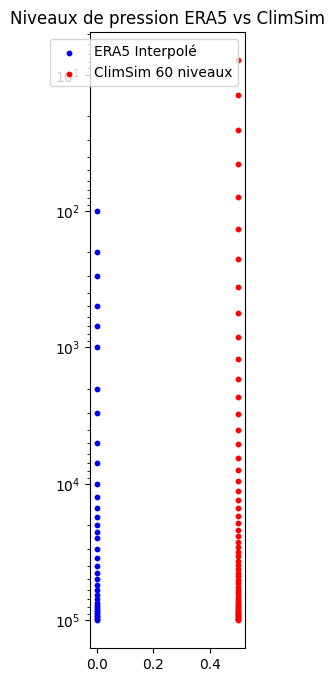

In [53]:
plt.figure(figsize=(2, 8))
plt.scatter(np.zeros(len(levels_hpa)), levels_hpa * 100, color='b', label='ERA5 Interpolé', s=10)
plt.scatter(np.ones(len(p_climsim_60))*0.5, p_climsim_60, color='r', label='ClimSim 60 niveaux', s=10)
plt.legend()
plt.yscale('log')
plt.gca().invert_yaxis()
plt.title("Niveaux de pression ERA5 vs ClimSim")

As you can already spot here, ERA 5 data doesn't go high enough to be fully representative of ClimSim data

In [73]:
# Facteur de conversion de Joule (1h) vers Watt
J_to_W = 1 / 3600.0
dt = 3600.0

data_dict = {
    'state_t': t_interpolated.flatten(), # On s'assure que c'est bien 1D (60,)
    'state_q0001': q_interpolated.flatten(),
    'state_ps': sp_val, 
    # Conversion J/m2 -> W/m2
    'pbuf_SOLIN': era5_surface_accum.tisr.values.flatten()[0] * J_to_W,
    'pbuf_LHFLX': era5_surface_accum.slhf.values.flatten()[0] * J_to_W,
    'pbuf_SHFLX': era5_surface_accum.sshf.values.flatten()[0] * J_to_W,
}

target_dict = {
    # Tendances (60 niveaux)
    'ptend_t': ptend_t_interp, 
    'ptend_q0001': ptend_q_interp,
    
    # Flux de surface (Scalaires)
    'cam_out_NETSW': era5_surface_accum.ssr.values.flatten()[1] * J_to_W,
    'cam_out_FLWDS': era5_surface_accum.strd.values.flatten()[1] * J_to_W,
    'cam_out_PRECC': era5_surface_accum.cp.values.flatten()[1] / dt, # m -> m/s
}

for extra in ['cam_out_SOLS', 'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD', "cam_out_PRECSC"]:
    target_dict[extra] = np.nan

# Création des Dataset
ds = xr.Dataset()
for var_name, values in data_dict.items():
    if var_name in ['state_t', 'state_q0001']:
        ds[var_name] = (('lev',), values)
    else:
        ds[var_name] = xr.DataArray(values)

ds_target = xr.Dataset()
for var_name, values in target_dict.items():
    if var_name in ['ptend_t', 'ptend_q0001']:
        clean_values = np.array(values).flatten()
        
        if len(clean_values) == 60:
            ds_target[var_name] = (('lev',), clean_values)
        else:
            print(f"Erreur : {var_name} a une taille de {len(clean_values)} au lieu de 60")
    else:
        ds_target[var_name] = xr.DataArray(np.array(values).item() if np.ndim(values) > 0 else values)

In [74]:
def normalize(ds_to_norm, is_input=True):
    normalized_ds = xr.Dataset()
    
    # On boucle sur les variables REELLEMENT présentes dans le dataset passé
    for var_name in ds_to_norm.data_vars:
        data = ds_to_norm[var_name].values  # (60,) ou ()
        
        # 2. Préparation du format (1, N) pour le normaliseur
        if 'lev' in ds_to_norm[var_name].dims:
            input_data = data[np.newaxis, :] # -> (1, 60)
        else:
            input_data = np.atleast_2d(data) # -> (1, 1)
        
        try:
            normalized_data = dataset._normalize_var(
                input_data, 
                var_name, 
                is_input=is_input
            ).squeeze()
            
            # 4. Stockage
            if 'lev' in ds_to_norm[var_name].dims:
                normalized_ds[var_name] = (('lev',), normalized_data)
            else:
                normalized_ds[var_name] = xr.DataArray(float(normalized_data))
        except KeyError:
            print(f"Variable {var_name} ignorée (pas de stats de normalisation)")
            
    return normalized_ds

norm_features = normalize(ds, is_input=True)
norm_target = normalize(ds_target, is_input=False)

In [75]:
def build_ml_vector(normalized_dataset, vars_list):
    vector_parts = []
    for var in vars_list:
        clean_name = re.sub(r'^(in_|out_)', '', var)
        val = normalized_dataset[clean_name].values
        
        if val.ndim == 0: # Scalaire (Surface)
            vector_parts.append(np.array([val]))
        else: # Profil (Vertical)
            vector_parts.append(val)
            
    return np.concatenate(vector_parts).astype(np.float32)

# Construction de X (Entrées)
x_vars = ["state_t", "state_q0001", "state_ps", "pbuf_SOLIN", "pbuf_LHFLX", "pbuf_SHFLX"]
X_input = build_ml_vector(norm_features, x_vars)
X_input = X_input[np.newaxis, :] # Ajout de la dimension Batch -> (1, 124)

# Construction de Y_true (Cibles réelles)
y_vars = ["ptend_t", "ptend_q0001", "cam_out_NETSW", "cam_out_FLWDS", "cam_out_PRECC", 
          "cam_out_SOLS", "cam_out_SOLL", "cam_out_SOLSD", "cam_out_SOLLD", "cam_out_PRECSC"]
Y_true = build_ml_vector(norm_target, y_vars)

pred_norm = mlp_model.predict(X_input, verbose=0)

Next plot are in NORMALIZED OUTPUT because denormalization is difficult to implement. However we can still findout that performance isn't here. To improve it we should probably work way more on adaptation pipeline

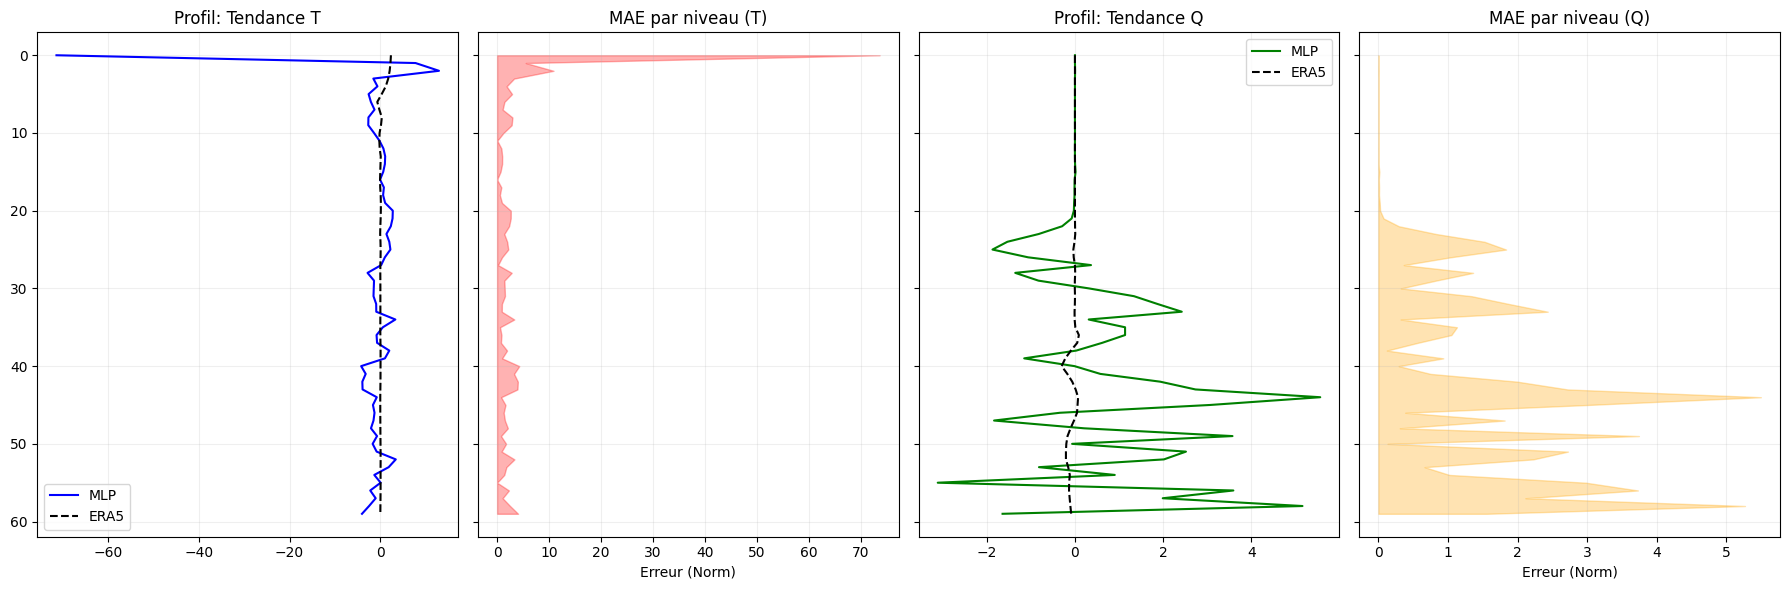

MAE Moyenne T: 3.1159
MAE Moyenne Q: 1.0203


In [76]:
var_indices = {
    "ptend_t": slice(0, 60),
    "ptend_q0001": slice(60, 120),
    "cam_out_NETSW": 120,
    "cam_out_FLWDS": 121,
    "cam_out_PRECC": 122,
    "cam_out_SOLS": 123,
    "cam_out_SOLL": 124,
    "cam_out_SOLSD": 125,
    "cam_out_SOLLD": 126,
    "cam_out_PRECSC": 127
}

# 1. Calcul des MAE par niveau (60, )
mae_t = np.abs(pred_norm[0, var_indices["ptend_t"]] - Y_true[var_indices["ptend_t"]])
mae_q = np.abs(pred_norm[0, var_indices["ptend_q0001"]] - Y_true[var_indices["ptend_q0001"]])

# 2. Plot des profils + MAE
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=True)

# --- Température ---
axes[0].plot(pred_norm[0, var_indices["ptend_t"]], range(60), 'b', label='MLP')
axes[0].plot(Y_true[var_indices["ptend_t"]], range(60), 'k--', label='ERA5')
axes[0].set_title("Profil: Tendance T")
axes[0].legend()

axes[1].fill_betweenx(range(60), 0, mae_t, color='red', alpha=0.3)
axes[1].set_title("MAE par niveau (T)")
axes[1].set_xlabel("Erreur (Norm)")

# --- Humidité ---
axes[2].plot(pred_norm[0, var_indices["ptend_q0001"]], range(60), 'g', label='MLP')
axes[2].plot(Y_true[var_indices["ptend_q0001"]], range(60), 'k--', label='ERA5')
axes[2].set_title("Profil: Tendance Q")
axes[2].legend()

axes[3].fill_betweenx(range(60), 0, mae_q, color='orange', alpha=0.3)
axes[3].set_title("MAE par niveau (Q)")
axes[3].set_xlabel("Erreur (Norm)")



plt.gca().invert_yaxis()
for ax in axes: ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# 3. Score global
print(f"MAE Moyenne T: {mae_t.mean():.4f}")
print(f"MAE Moyenne Q: {mae_q.mean():.4f}")

In [77]:
import pandas as pd

# 1. Extraction et calcul
surface_labels = [k for k, v in var_indices.items() if isinstance(v, int)]
p_surf = np.array([pred_norm[0, var_indices[k]] for k in surface_labels])
t_surf = np.array([Y_true[var_indices[k]] for k in surface_labels])

mae_surf = np.abs(p_surf - t_surf)
rel_err = (mae_surf / (np.abs(t_surf) + 1e-10)) * 100

# 2. Création du DataFrame
df_stats = pd.DataFrame({
    'Variable': surface_labels,
    'MLP (Norm)': p_surf,
    'ERA5 (Norm)': t_surf,
    'MAE': mae_surf,
    'Rel Error %': rel_err
})

# 3. Affichage formaté
print("\n" + "="*70)
print("STATISTIQUES D'ERREUR SUR LES VARIABLES DE SURFACE")
print("="*70)
print(df_stats.to_string(index=False, justify='center', formatters={
    'MLP (Norm)': '{:+.4e}'.format,
    'ERA5 (Norm)': '{:+.4e}'.format,
    'MAE': '{:.4e}'.format,
    'Rel Error %': '{:.2f}%'.format
}))
print("="*70)


STATISTIQUES D'ERREUR SUR LES VARIABLES DE SURFACE
   Variable     MLP (Norm) ERA5 (Norm)    MAE     Rel Error %
 cam_out_NETSW +0.0000e+00 +2.4000e-18 2.4000e-18     0.00%  
 cam_out_FLWDS +5.5516e+00 +2.0884e+00 3.4631e+00   165.83%  
 cam_out_PRECC +0.0000e+00 +0.0000e+00 0.0000e+00     0.00%  
  cam_out_SOLS +0.0000e+00         NaN        NaN       NaN  
  cam_out_SOLL +0.0000e+00         NaN        NaN       NaN  
 cam_out_SOLSD +0.0000e+00         NaN        NaN       NaN  
 cam_out_SOLLD +0.0000e+00         NaN        NaN       NaN  
cam_out_PRECSC +0.0000e+00         NaN        NaN       NaN  


NETSW 0% error comes from the fact that we tried the pipeline on a night sample

As with level variables, surface performance is quite poor (which was expected because of the lack of precision on the adpatation pipeline and the sensitivity of deep learning to the input)